# EDA: Winemag Data
<b>8/18/2018</b><br>
Space to explore [WineMag data](https://www.kaggle.com/zynicide/wine-reviews/home), develop hypotheses to test.

<hr>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# load data
df = pd.read_csv('./data/winemag-data-130k-v2.csv', index_col=0)

In [4]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Initial Questions

Off the bat, I have half a dozen questions:
- What features affect `points`?
    - How much of an effect does price have? Province? Region? Varietal?
- What are the regions with the greatest markups in Washington?
- Controlling for other factors, what varietal has the most expensive wines?
- What about the Winery? Most expensive? Hightest rated? Most consistent?
- Description features of the highest scoring wines? Common descriptive features for Countries, regions, etc?

## Description of Data
First thing's first: we need to get to know our data. Here are our initial features:

- `country`: Country of origin for wine.
- `province`: Province or state.
- `region_1`: Wine growing region.
- `region_2`: Sub-region, if in one.
- `winery`: Name of winery.
- `designation`: Specific vineyard of wine.
- `variety`: Variety of grape used.
- `title`: Name of wine (includes year)
- `points`: WineEnthusiast points.
- `price`: Price (in dollars?)
- `description`: Excerpt of tasting notes from a sommelier.
- `taster_name`: Name of taster/reviewer.
- `taster_twitter_handle`: Twitter handle of taster/reviewer.

We have information on where a wine is from, what kind of wine it is, a subjective description and review, the reviewer, and a subjective score.

It's important to note the subjectivity of `points` and `description`. We may consider them to be aspects of a review, and are thus partially dependent on `taster_name` - the reviewer. Reviewers may have biases that are reflected in both the points they award a wine and the way in which they describe it. Because we're interested in modeling  `points`, we may need to find a way to adjust for these biases in order to normalize `points`.

Notably, there isn't a feature for `vintage` - the year in which the wine was made. This is an important feature. Many factors that aren't listed - weather, harvest date, winemaker, etc. - are dependent on year, and the same wine from different yeas may have a significant difference in `points`. We'll need to engineer it.

It's also worth noting that the `description` contains a wealth of features (tasting adjectives such as 'blueberries', and 'pepper') that we may want to mine.

## Data Cleaning + Initial Feature Engineering
Before progressing, we need to clean our data and validate its quality. Specifically:
- Determine how to handle Null values
- Look for bad data points (outliers, high leverage)
- Determine if it's of a high enough quality answer the questions we're interested in.

In [12]:
# check for null columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


### Location Features for Wines Vary
We should also note that the way a wine's location is described varies. For example, the most specific location feature is `designation` - the specific vineyard a wine is from. As many wines are made from grapes sourced from different vineyards, we expect this feature to have a lot of null values.

In [27]:
# wines with no designation
df[df.designation.isnull()].shape[0]

37465

However, many wines are missing other location parameters:

In [34]:
# wines with no location parameters
df[df.designation.isnull() & df.region_1.isnull() & df.region_2.isnull() & df.province.isnull()].shape[0]

11

In [35]:
# wines with only designation
df[~df.designation.isnull() & df.region_1.isnull() & df.region_2.isnull() & df.province.isnull()].shape[0]

52

In [37]:
# wines with only region
df[df.designation.isnull() & ~df.region_1.isnull() & df.province.isnull()].shape[0]

0

In [39]:
# wines with only province
df[df.designation.isnull() & df.region_1.isnull() & df.region_2.isnull() & ~df.province.isnull()].shape[0]

3766

What's going on? It turns out that how you describe the location of a wine varies by country. For example, 

In [23]:
# wines with no region, by country
df[df.region_1.isnull() & df.region_2.isnull()][['country', 'province']].groupby('country')\
    .count()\
    .sort_values('province', ascending=False).head(10)

,province
country,
Portugal,5691
Chile,4472
Austria,3345
Germany,2165
New Zealand,1419
South Africa,1401
Israel,505
Greece,466
US,278


In [ ]:
df[['country', 'province']].groupby('country')

# count without region by country
df[df.region_1.isnull() & df.region_2.isnull()][['country', 'province']].groupby('country')\
    .count()\
    
    
    .sort_values('province', ascending=False).head(10)

#### Get % of wines with location parameter, by country

In [82]:
# create location df
df_location = df[['title', 'country']].copy()

# add binary vars for location parameters
df_location['has_designation'] = ~df.designation.isnull()
df_location['has_province'] = ~df.province.isnull()
df_location['has_winery'] = ~df.winery.isnull()
df_location['has_region'] = ~(df.region_1.isnull() & df.region_2.isnull())

# get counts of wines, sums of binary vars by country
df_location_by_country = df_location.groupby('country').agg({
                                'title': 'count',
                                'has_designation': 'sum',
                                'has_province': 'sum',
                                'has_winery': 'sum',
                                'has_region': 'sum'
                            })

df_location_by_country.rename(columns={'title': 'wines'}, inplace=True)

# change counts to % values, rename columns
location_cols = ['province', 'region', 'winery', 'designation']
for col_name in location_cols:
    col = f'has_{col_name}'
    df_location_by_country[col] = df_location_by_country[col] / df_location_by_country['wines']
    df_location_by_country[col] = df_location_by_country[col].apply(lambda x: round(x*100, 2))
    df_location_by_country.rename(columns={col: f'%_{col}'}, inplace=True)

# show top 15 countries by wine count
df_location_by_country.sort_values('wines', ascending=False).head(15)

,wines,%_has_designation,%_has_province,%_has_winery,%_has_region
country,,,,,
US,54504,67.72,100.0,100.0,99.49
France,22093,65.77,100.0,100.0,99.66
Italy,19540,71.08,100.0,100.0,99.86
Spain,6645,80.06,100.0,100.0,99.88
Portugal,5691,89.70,100.0,100.0,0.00
Chile,4472,86.74,100.0,100.0,0.00
Argentina,3800,76.37,100.0,100.0,98.61
Austria,3345,84.45,100.0,100.0,0.00
Australia,2329,70.42,100.0,100.0,99.91


So, we can see that location designations can vary by country. We'll handle these discrepencies by introducing a new value, `NA`.

### Add `NA` to Location Columns

In [5]:
location_cols = ['province', 'region_1', 'region_2', 'winery', 'designation']

In [6]:
# convert np.NaN to string `NA`
convert_null = lambda val: 'NA' if (type(val) != str and np.isnan(val)) else val
for col in location_cols:
    df[col] = df[col].apply(convert_null)

In [5]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NA,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NA,NA,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NA,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NA,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Add Vintage Feature

In [ ]:
import string

In [28]:
# extract vintage feature from title
def extract_vintage(title):
    for tk in title.split():
        clean_tk = tk.strip(string.punctuation)
        if clean_tk.isdigit():
            return clean_tk

In [30]:
df['vintage'] = df.title.apply(extract_vintage)

In [33]:
df[df.vintage.isnull()]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,vintage
63,France,"This fat, yeasty Champagne is comprised predom...",Brut Rosé,86,58.0,Champagne,Champagne,NA,Roger Voss,@vossroger,Roland Champion NV Brut Rosé (Champagne),Champagne Blend,Roland Champion,None
69,France,"This cooperative, based in Aÿ, has benefited f...",Brut Rosé,86,55.0,Champagne,Champagne,NA,Roger Voss,@vossroger,Collet NV Brut Rosé (Champagne),Champagne Blend,Collet,None
237,Italy,The wine boasts a beautiful appearance thanks ...,NA,85,18.0,Central Italy,San Marino,NA,NaN,NaN,Consorzio Vini Tipici di San Marino NV Moscato...,Moscato,Consorzio Vini Tipici di San Marino,None
315,Italy,"Honey, almond blossom and citrus zest are foll...",Extra Dry,86,15.0,Veneto,Prosecco di Valdobbiadene,NA,NaN,NaN,Bellussi NV Extra Dry (Prosecco di Valdobbiad...,Prosecco,Bellussi,None
326,Italy,Drying mineral tones face off with luscious pe...,Extra Dry,86,15.0,Veneto,Prosecco di Valdobbiadene,NA,NaN,NaN,Marsuret NV Extra Dry (Prosecco di Valdobbiad...,Prosecco,Marsuret,None
332,Italy,This Prosecco Brut from the slightly warmer Co...,Palazzo Rosso Brut,86,19.0,Veneto,Prosecco di Conegliano,NA,NaN,NaN,Sommariva NV Palazzo Rosso Brut (Prosecco di ...,Prosecco,Sommariva,None
333,Italy,This crisp sparkler is characterized by drying...,Col del Sas Extra Dry,86,18.0,Veneto,Prosecco di Valdobbiadene,NA,NaN,NaN,Spagnol NV Col del Sas Extra Dry (Prosecco di...,Prosecco,Spagnol,None
334,France,"A ripe, fruity wine that takes its raspberry f...",Mosaïque Rosé Brut,86,42.0,Champagne,Champagne,NA,Roger Voss,@vossroger,Jacquart NV Mosaïque Rosé Brut (Champagne),Champagne Blend,Jacquart,None
342,Spain,"Funky, yeasty aromas of cinnamon, spent lees a...",NA,82,11.0,Catalonia,Cava,NA,Michael Schachner,@wineschach,Bellisco NV Sparkling (Cava),Sparkling Blend,Bellisco,None
345,Australia,This wine contains some material over 100 year...,Rare,100,350.0,Victoria,Rutherglen,NA,Joe Czerwinski,@JoeCz,Chambers Rosewood Vineyards NV Rare Muscat (Ru...,Muscat,Chambers Rosewood Vineyards,None


It seems that nearly all wines missing the `vintage` feature are sparkling wines (champagne, prosecco, etc.). We should feel okay restricting our consideration to traditional non-sparkling wine and dropping these observations.

### EDA

In [8]:
from scipy.stats import norm

In [9]:
# fix odd name character
df['taster_name'] = df.taster_name.apply(lambda name: name if name != 'Anne Krebiehl\xa0MW' else 'Anne Krebiehl')

# get tasters
tasters = [name for name in df.taster_name.unique() if type(name) == str]

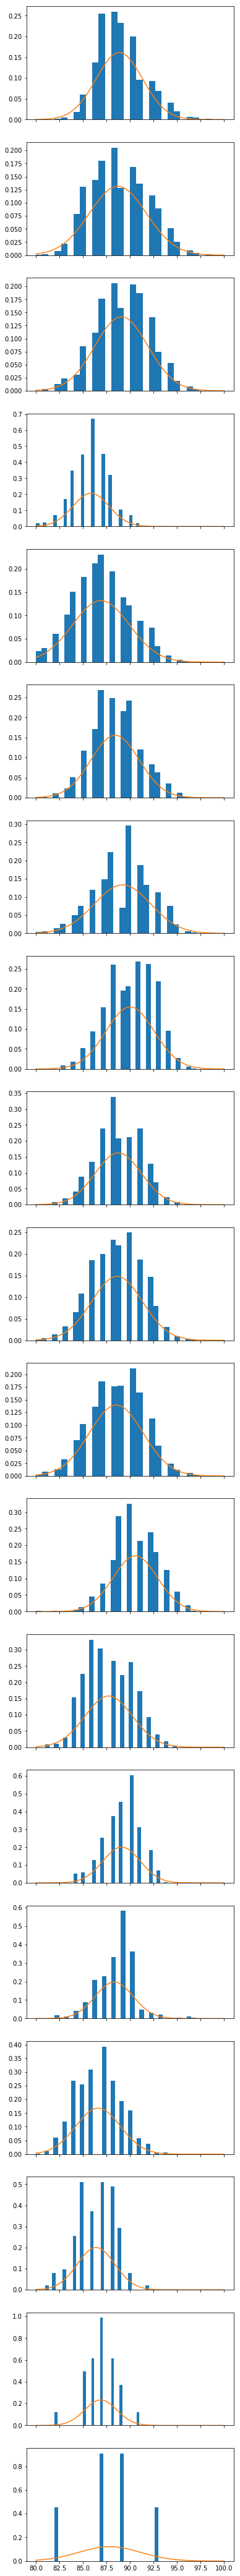

In [10]:
fig, ax = plt.subplots(
    nrows=len(tasters),
    ncols=1,
    figsize=(6, 4*len(tasters)),
    sharex=True
)

# get range for x-axis
x_min, x_max = df.points.min(), df.points.max()
x = np.linspace(x_min, x_max, 100)

for name, row in zip(tasters, ax):
    
    # plot histogram
    points = df[df.taster_name == name].points
    row.hist(points, density=True, bins=30)
    
    # plot normal distribution
    mu, std = norm.fit(points)
    row.plot(x, norm.pdf(x, mu, std))

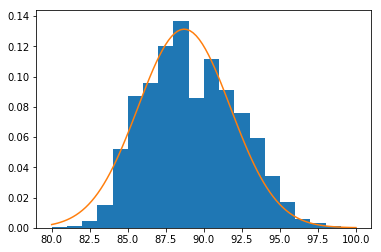

In [11]:
def test_plot_norm(points):
    # get x axis
    x_min, x_max = df.points.min(), df.points.max()
    x = np.linspace(x_min, x_max, 100)
    
    mu, std = norm.fit(points)
    plt.hist(points, bins=20, density=True)
    
    plt.plot(x, norm.pdf(x, mu, std))
             
test_plot_norm(df[df.taster_name=='Roger Voss'].points)

In [ ]:
# difference b/t distributions of scores by varietal (p-values of difference?)

In [ ]:
# heatmap of world/wine regions by avg price?

In [13]:
df[df.country == 'US'].groupby('province').agg({'price': 'mean', 'title': 'count'}).sort_values('price', ascending=False)

,price,title
province,,
California,39.041048,36247
Nevada,37.750000,4
Oregon,36.545064,5373
Kentucky,35.000000,1
Colorado,32.985294,68
Washington,32.436444,8639
Michigan,32.432432,114
Illinois,32.333333,6
Vermont,31.666667,3


In [6]:
df[df.province=='Oregon'].groupby(['region_2', 'region_1']).agg({'price': 'mean', 'title': 'count'}).sort_values('price', ascending=False)

price  title
region_2          region_1                                 
NA                NA                       70.000000      1
                  Oregon Other             61.666667      3
Oregon Other      Walla Walla Valley (OR)  57.991597    119
Willamette Valley Dundee Hills             53.039711    554
                  Chehalem Mountains       47.071856    334
NA                Willamette Valley        46.761589    302
Willamette Valley Ribbon Ridge             45.857143    134
                  McMinnville              44.080645    124
                  Eola-Amity Hills         42.905455    276
Oregon Other      Polk County              40.000000      2
Willamette Valley Yamhill County           37.500000      2
                  Willamette Valley        33.262788   1999
Oregon Other      Columbia Valley (OR)     32.438356     73
Southern Oregon   Applegate Valley         31.568627    153
Oregon Other      Columbia Gorge (OR)      28.492958     73
Southern Oregon   Southern Oregon          26.859504    122
                  Umpqua Valley            26.352174    232
                  Rogue Valley             25.287206    384
Oregon Other      Oregon                   23.612200    460
Southern Oregon   Elkton Oregon            21.576923     26

In [23]:
df_var = df[(df.country=='US') & (df.province=='California')]\
            .groupby(['variety'])\
            .agg({'title': 'count',
                  'price': 'mean',
                  'points': 'mean'})\
            .sort_values('price', ascending=False)
            
df_var[df_var.title >= 10]

,title,price,points
variety,,,
Bordeaux-style Red Blend,876,73.949772,89.823059
Cabernet Blend,20,60.100000,88.950000
Claret,22,60.090909,89.000000
Cabernet Sauvignon,5693,59.173077,89.064114
Petite Verdot,14,58.071429,88.785714
Syrah-Cabernet Sauvignon,18,47.000000,89.500000
Cabernet Franc,361,45.326816,88.351801
Syrah-Petite Sirah,10,45.300000,89.800000
Cabernet Sauvignon-Merlot,17,45.117647,87.882353


In [37]:
df_var = df[(df.country=='France') & (df.province=='Bordeaux')]\
            .groupby(['variety', 'vintage'])\
            .agg({'title': 'count',
                  'price': 'mean',
                  'points': 'mean'})\
            .sort_values('price', ascending=False)
            
df_var[df_var.title >= 10]\
    .reset_index()\
    .sort_values(['variety', 'vintage', 'points'], ascending=False)

,variety,vintage,title,price,points
23,Sauvignon Blanc,2014,10,24.875000,86.900000
27,Sauvignon Blanc,2013,12,20.166667,87.250000
32,Sauvignon Blanc,2012,10,15.500000,86.400000
33,Rosé,2016,66,14.746032,86.227273
34,Rosé,2015,55,13.775510,86.036364
35,Rosé,2014,50,13.432432,84.560000
11,Merlot,2014,18,43.588235,88.611111
17,Merlot,2012,12,37.250000,88.166667
24,Merlot,2010,10,24.300000,86.900000
31,Bordeaux-style White Blend,2016,109,15.568807,86.972477


True